In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image
from io import BytesIO

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
%matplotlib inline

In [3]:
#  参数设定
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#  超参设定
BATCH_SIZE = 128
BATCH_SIZE_LOW = 48
LEARNING_RATE = 0.00001
NUM_EPOCHS = 60
RANDOM_SEED = 1
NUM_FEATURES = 784

NUM_CLASSES = 3
GRAYSCALE = False

In [4]:
#  混淆矩阵函数
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def draw_confusion_matrix(loader, model, labels, num_classes, device):
    
    conf_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for idx, (features, targets) in enumerate(loader):

            targets = targets.squeeze()
            targets = targets.to(device)
            features = features.to(device)

            _, pred = model(features)

            conf_matrix = confusion_matrix(pred, targets, conf_matrix)
            conf_matrix = conf_matrix.cpu()
            
    conf_matrix=np.array(conf_matrix.cpu())# 将混淆矩阵从gpu转到cpu再转到np
    corrects=conf_matrix.diagonal(offset=0)#抽取对角线的每种分类的识别正确个数
    per_kinds=conf_matrix.sum(axis=1)#抽取每个分类数据总的测试条数

    print("混淆矩阵总元素个数：{0},测试集总个数:{1}".format(int(np.sum(conf_matrix)),int(np.sum(conf_matrix))))
    print(conf_matrix)
    
    plt.imshow(conf_matrix, cmap = plt.cm.Blues)

    thresh = conf_matrix.max() / 2
    for x in range(num_classes):
        for y in range(num_classes):
            info = int(conf_matrix[y, x])
            plt.text(x, y, info,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color="white" if info > thresh else "black")

    plt.tight_layout()
    plt.yticks(range(num_classes), labels)
    plt.xticks(range(num_classes), labels,rotation=45)
    plt.show()
    plt.close()

In [5]:
#  创建两类数据集 -> 白人、黑人、其他人种

class RaceDatasetsHigh(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[1] == 'white':
                self.y.append(0)
            elif i.split('.')[1] == 'black':
                self.y.append(1)
            elif i.split('.')[1] == 'asian':
                self.y.append(2)
            elif i.split('.')[1] == 'hispanic':
                self.y.append(2)
            elif i.split('.')[1] == 'other':
                self.y.append(2)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
custom_transform1 = transforms.Compose([transforms.Resize([128, 128]),
                                       transforms.ToTensor()])

train_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'train'),
                            transform=custom_transform1)

train_high_loader = DataLoader(dataset = train_high_dataset,
                        batch_size = 256,
                        shuffle = False)

train_high_mean = []
train_high_std = []


for i, image in enumerate(train_high_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_high_mean.append(batch_mean)
    train_high_std.append(batch_std)

train_high_mean = torch.tensor(np.mean(train_high_mean, axis=0))
train_high_std = torch.tensor(np.mean(train_high_std, axis=0))

print('Mean:', train_high_mean)
print('Std Dev:', train_high_std)

Mean: tensor([0.1876, 0.1876, 0.1876])
Std Dev: tensor([0.2800, 0.2800, 0.2800])


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_high_mean, train_high_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_high_mean, train_high_std)
    ]),
}

train_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'train'),
                            transform=data_transforms['train'])

train_high_loader = DataLoader(dataset = train_high_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'test'),
                            transform=data_transforms['test'])

test_high_loader = DataLoader(dataset = test_high_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

for images, labels in train_high_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
for images, labels in test_high_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])


In [7]:
#  创建两类数据集 -> 亚洲人、西班牙人、其他人种

class RaceDatasetsLow(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[1] == 'asian':
                self.y.append(0)
            elif i.split('.')[1] == 'hispanic':
                self.y.append(1)
            elif i.split('.')[1] == 'other':
                self.y.append(2)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
custom_transform1 = transforms.Compose([transforms.Resize([128, 128]),
                                       transforms.ToTensor()])

train_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetrain'),
                            transform=custom_transform1)

train_low_loader = DataLoader(dataset = train_low_dataset,
                        batch_size = 256,
                        shuffle = False)

train_low_mean = []
train_low_std = []


for i, image in enumerate(train_low_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_low_mean.append(batch_mean)
    train_low_std.append(batch_std)

train_low_mean = torch.tensor(np.mean(train_low_mean, axis=0))
train_low_std = torch.tensor(np.mean(train_low_std, axis=0))

print('Mean:', train_low_mean)
print('Std Dev:', train_low_std)

Mean: tensor([0.2077, 0.2077, 0.2077])
Std Dev: tensor([0.2873, 0.2873, 0.2873])


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_low_mean, train_low_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_low_mean, train_low_std)
    ]),
}

train_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetrain'),
                            transform=data_transforms['train'])

train_low_loader = DataLoader(dataset = train_low_dataset,
                        batch_size = BATCH_SIZE_LOW,
                        shuffle = True)

test_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetest'),
                            transform=data_transforms['test'])

test_low_loader = DataLoader(dataset = test_low_dataset,
                        batch_size = BATCH_SIZE_LOW,
                        shuffle = False)

for images, labels in train_low_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
for images, labels in test_low_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([48, 3, 128, 128])
Image label dimensions: torch.Size([48])
Image batch dimensions: torch.Size([48, 3, 128, 128])
Image label dimensions: torch.Size([48])


In [43]:
#  创建模型 -> resnet18

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [95]:
#  训练

torch.manual_seed(RANDOM_SEED)

model_high_res = resnet18(NUM_CLASSES)
model_high_res.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_high_res.parameters(), lr=LEARNING_RATE)

In [96]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    
def every_kind_accuracy(model, data_loader, device):
    classes = ['WHITE', 'BLACK', 'OTHER']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    every_kind = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        for label, prediction in zip(targets, predicted_labels):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        every_kind.append(accuracy)
    return every_kind

start_time = time.time()

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
res_train_acc_lst, res_test_acc_lst = [], []
res_train_loss_lst, res_test_loss_lst = [], []
res_WHITE_ACC, res_BLACK_ACC, res_OTHER_ACC = [], [], []

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path_save = '/home/rush/Face_Recognize/save/res_high/'
best_acc = 75
best_every_acc_res_high = []

for epoch in range(NUM_EPOCHS):
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_high_res.train()
    
    for batch_idx, (features, targets) in enumerate(train_high_loader):
    
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        logits, probas = model_high_res(features)
        cost = cost_fn(logits, targets)
        '''
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0, 1.0, 1.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        '''
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 8:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_high_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_high_res.eval()
    with torch.set_grad_enabled(False):
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        train_acc, train_loss = compute_accuracy_and_loss(model_high_res, train_high_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model_high_res, test_high_loader, device=DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        res_train_acc_lst.append(train_acc)
        res_test_acc_lst.append(test_acc)
        res_train_loss_lst.append(train_loss)
        res_test_loss_lst.append(test_loss)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        every_acc = every_kind_accuracy(model_high_res, test_high_loader, device = DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        res_WHITE_ACC.append(every_acc[0])
        res_BLACK_ACC.append(every_acc[1])
        res_OTHER_ACC.append(every_acc[2])
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | test Acc.: {test_acc:.2f}%')
        
    if test_acc > best_acc:
        best_acc = test_acc
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # best_every_acc_res_high = every_acc
        torch.save(model_high_res.state_dict(), path_save + f'{best_acc:.3f}.pt')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/060 | Batch 000/021 | Cost: 1.0571
Epoch: 001/060 | Batch 008/021 | Cost: 1.0115
Epoch: 001/060 | Batch 016/021 | Cost: 0.9670
Accuracy for class WHITE is: 0.0 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 100.0 %
Epoch: 001/060 Train Acc.: 60.87% | test Acc.: 2.40%
Time elapsed: 0.29 min
Epoch: 002/060 | Batch 000/021 | Cost: 0.9325
Epoch: 002/060 | Batch 008/021 | Cost: 0.8931
Epoch: 002/060 | Batch 016/021 | Cost: 0.8698
Accuracy for class WHITE is: 1.5 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 97.9 %
Epoch: 002/060 Train Acc.: 61.10% | test Acc.: 3.61%
Time elapsed: 0.57 min
Epoch: 003/060 | Batch 000/021 | Cost: 0.8430
Epoch: 003/060 | Batch 008/021 | Cost: 0.7984
Epoch: 003/060 | Batch 016/021 | Cost: 0.7804
Accuracy for class WHITE is: 78.3 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 22.9 %
Epoch: 003/060 Train Acc.: 72.89% | test Acc.: 67.18%
Time elapsed: 0.86 min
Epoch: 004/060 | Batch 000/021 | Cost

Accuracy for class WHITE is: 80.2 %
Accuracy for class BLACK is: 76.7 %
Accuracy for class OTHER is: 14.6 %
Epoch: 026/060 Train Acc.: 92.15% | test Acc.: 78.16%
Time elapsed: 7.54 min
Epoch: 027/060 | Batch 000/021 | Cost: 0.2762
Epoch: 027/060 | Batch 008/021 | Cost: 0.2371
Epoch: 027/060 | Batch 016/021 | Cost: 0.1834
Accuracy for class WHITE is: 81.5 %
Accuracy for class BLACK is: 65.5 %
Accuracy for class OTHER is: 14.6 %
Epoch: 027/060 Train Acc.: 93.74% | test Acc.: 77.86%
Time elapsed: 7.83 min
Epoch: 028/060 | Batch 000/021 | Cost: 0.2136
Epoch: 028/060 | Batch 008/021 | Cost: 0.2336
Epoch: 028/060 | Batch 016/021 | Cost: 0.1864
Accuracy for class WHITE is: 76.8 %
Accuracy for class BLACK is: 51.8 %
Accuracy for class OTHER is: 37.5 %
Epoch: 028/060 Train Acc.: 93.43% | test Acc.: 72.75%
Time elapsed: 8.12 min
Epoch: 029/060 | Batch 000/021 | Cost: 0.2318
Epoch: 029/060 | Batch 008/021 | Cost: 0.1601
Epoch: 029/060 | Batch 016/021 | Cost: 0.1521
Accuracy for class WHITE is: 72

Epoch: 052/060 | Batch 000/021 | Cost: 0.0708
Epoch: 052/060 | Batch 008/021 | Cost: 0.0775
Epoch: 052/060 | Batch 016/021 | Cost: 0.0817
Accuracy for class WHITE is: 62.5 %
Accuracy for class BLACK is: 48.6 %
Accuracy for class OTHER is: 54.2 %
Epoch: 052/060 Train Acc.: 96.06% | test Acc.: 60.57%
Time elapsed: 15.08 min
Epoch: 053/060 | Batch 000/021 | Cost: 0.0771
Epoch: 053/060 | Batch 008/021 | Cost: 0.0746
Epoch: 053/060 | Batch 016/021 | Cost: 0.0825
Accuracy for class WHITE is: 71.9 %
Accuracy for class BLACK is: 48.6 %
Accuracy for class OTHER is: 54.2 %
Epoch: 053/060 Train Acc.: 96.37% | test Acc.: 68.59%
Time elapsed: 15.37 min
Epoch: 054/060 | Batch 000/021 | Cost: 0.0757
Epoch: 054/060 | Batch 008/021 | Cost: 0.0460
Epoch: 054/060 | Batch 016/021 | Cost: 0.0837
Accuracy for class WHITE is: 71.3 %
Accuracy for class BLACK is: 61.8 %
Accuracy for class OTHER is: 41.7 %
Epoch: 054/060 Train Acc.: 98.69% | test Acc.: 69.44%
Time elapsed: 15.65 min
Epoch: 055/060 | Batch 000/0

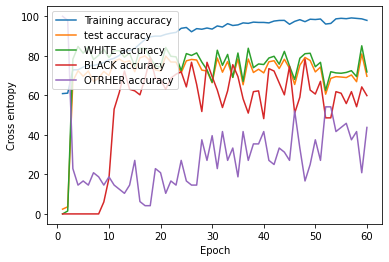

In [97]:
for i in range(len(res_train_acc_lst)):
    res_train_acc_lst[i] = res_train_acc_lst[i].cpu()
    
for j in range(len(res_test_acc_lst)):
    res_test_acc_lst[j] = res_test_acc_lst[j].cpu()

plt.plot(range(1, NUM_EPOCHS+1), res_train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_test_acc_lst, label='test accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_WHITE_ACC, label='WHITE accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_BLACK_ACC, label='BLACK accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_OTHER_ACC, label='OTRHER accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

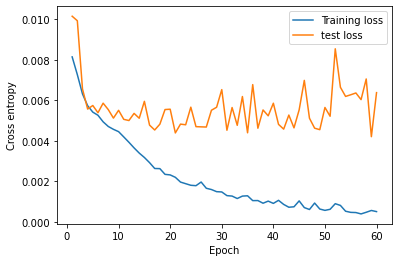

In [98]:
plt.plot(range(1, NUM_EPOCHS+1), res_train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), res_test_loss_lst, label='test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

混淆矩阵总元素个数：1996,测试集总个数:1996
[[1220.   46.   23.]
 [  91.  149.    4.]
 [ 388.   54.   21.]]


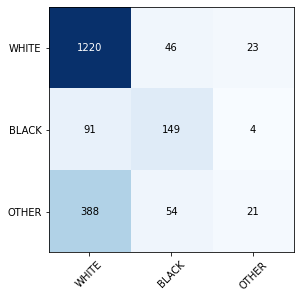

In [99]:
labels = ['WHITE', 'BLACK', 'OTHER']

draw_confusion_matrix(test_high_loader, model_high_res, labels, NUM_CLASSES, DEVICE)

In [101]:
torch.manual_seed(RANDOM_SEED)

model_low_res = resnet18(NUM_CLASSES)
model_low_res.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_low_res.parameters(), lr=LEARNING_RATE)

In [102]:
def every_kind_accuracy(model, data_loader, device):
    classes = ['ASIAN', 'HISPANIC', 'OTHER']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    every_kind = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        for label, prediction in zip(targets, predicted_labels):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        #print(total_pred)
            
    for classname, correct_count in correct_pred.items():
        if(total_pred[classname] == 0):
            accuracy = 0.1
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            every_kind.append(accuracy)
        else:
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            every_kind.append(accuracy)
    return every_kind

start_time = time.time()

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
res_low_train_acc_lst, res_low_test_acc_lst = [], []
res_low_train_loss_lst, res_low_test_loss_lst = [], []
res_low_ASIAN_ACC, res_low_HISPANIC_ACC, res_low_OTHER_ACC = [], [], []

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path_save = '/home/rush/Face_Recognize/save/res_low/'
best_acc = 50
best_every_acc_res_low = []

for epoch in range(NUM_EPOCHS):
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_low_res.train()

    for batch_idx, (features, targets) in enumerate(train_low_loader):
    
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        logits, probas = model_low_res(features)
        cost = cost_fn(logits, targets)
        '''
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0, 1.0, 1.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        '''
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 8:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_low_loader):03d} |'
                   f' Cost: {cost:.4f}')

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_low_res.eval()
    with torch.set_grad_enabled(False):
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        train_acc, train_loss = compute_accuracy_and_loss(model_low_res, train_low_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model_low_res, test_low_loader, device=DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        res_low_train_acc_lst.append(train_acc)
        res_low_test_acc_lst.append(test_acc)
        res_low_train_loss_lst.append(train_loss)
        res_low_test_loss_lst.append(test_loss)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        every_acc = every_kind_accuracy(model_low_res, test_low_loader, device = DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        res_low_ASIAN_ACC.append(every_acc[0])
        res_low_HISPANIC_ACC.append(every_acc[1])
        res_low_OTHER_ACC.append(every_acc[2])
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | test Acc.: {test_acc:.2f}%')
        
    if test_acc > best_acc:
        best_acc = test_acc
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        best_every_acc_res_low = every_acc
        torch.save(model_high_res.state_dict(), path_save + f'{best_acc:.3f}.pt')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/060 | Batch 000/033 | Cost: 1.1243
Epoch: 001/060 | Batch 008/033 | Cost: 1.1029
Epoch: 001/060 | Batch 016/033 | Cost: 1.0862
Epoch: 001/060 | Batch 024/033 | Cost: 1.1106
Epoch: 001/060 | Batch 032/033 | Cost: 1.1021
Accuracy for class ASIAN is: 76.9 %
Accuracy for class HISPANIC is: 0.0 %
Accuracy for class OTHER is: 33.3 %
Epoch: 001/060 Train Acc.: 36.34% | test Acc.: 47.92%
Time elapsed: 0.11 min
Epoch: 002/060 | Batch 000/033 | Cost: 1.0927
Epoch: 002/060 | Batch 008/033 | Cost: 1.0908
Epoch: 002/060 | Batch 016/033 | Cost: 1.0831
Epoch: 002/060 | Batch 024/033 | Cost: 1.0882
Epoch: 002/060 | Batch 032/033 | Cost: 1.0832
Accuracy for class ASIAN is: 69.2 %
Accuracy for class HISPANIC is: 0.0 %
Accuracy for class OTHER is: 55.6 %
Epoch: 002/060 Train Acc.: 41.87% | test Acc.: 47.92%
Time elapsed: 0.22 min
Epoch: 003/060 | Batch 000/033 | Cost: 1.0969
Epoch: 003/060 | Batch 008/033 | Cost: 1.0862
Epoch: 003/060 | Batch 016/033 | Cost: 1.0599
Epoch: 003/060 | Batch 024/0

Epoch: 021/060 | Batch 008/033 | Cost: 0.6326
Epoch: 021/060 | Batch 016/033 | Cost: 0.4707
Epoch: 021/060 | Batch 024/033 | Cost: 0.5418
Epoch: 021/060 | Batch 032/033 | Cost: 0.6535
Accuracy for class ASIAN is: 76.9 %
Accuracy for class HISPANIC is: 30.8 %
Accuracy for class OTHER is: 44.4 %
Epoch: 021/060 Train Acc.: 75.54% | test Acc.: 58.33%
Time elapsed: 2.40 min
Epoch: 022/060 | Batch 000/033 | Cost: 0.4312
Epoch: 022/060 | Batch 008/033 | Cost: 0.5335
Epoch: 022/060 | Batch 016/033 | Cost: 0.4792
Epoch: 022/060 | Batch 024/033 | Cost: 0.6024
Epoch: 022/060 | Batch 032/033 | Cost: 0.4543
Accuracy for class ASIAN is: 57.7 %
Accuracy for class HISPANIC is: 46.2 %
Accuracy for class OTHER is: 55.6 %
Epoch: 022/060 Train Acc.: 84.31% | test Acc.: 54.17%
Time elapsed: 2.52 min
Epoch: 023/060 | Batch 000/033 | Cost: 0.4345
Epoch: 023/060 | Batch 008/033 | Cost: 0.3857
Epoch: 023/060 | Batch 016/033 | Cost: 0.4164
Epoch: 023/060 | Batch 024/033 | Cost: 0.4470
Epoch: 023/060 | Batch 032

Epoch: 041/060 | Batch 008/033 | Cost: 0.1729
Epoch: 041/060 | Batch 016/033 | Cost: 0.1259
Epoch: 041/060 | Batch 024/033 | Cost: 0.1116
Epoch: 041/060 | Batch 032/033 | Cost: 0.1612
Accuracy for class ASIAN is: 53.8 %
Accuracy for class HISPANIC is: 46.2 %
Accuracy for class OTHER is: 55.6 %
Epoch: 041/060 Train Acc.: 97.46% | test Acc.: 52.08%
Time elapsed: 4.69 min
Epoch: 042/060 | Batch 000/033 | Cost: 0.0852
Epoch: 042/060 | Batch 008/033 | Cost: 0.1452
Epoch: 042/060 | Batch 016/033 | Cost: 0.1475
Epoch: 042/060 | Batch 024/033 | Cost: 0.1418
Epoch: 042/060 | Batch 032/033 | Cost: 0.1569
Accuracy for class ASIAN is: 53.8 %
Accuracy for class HISPANIC is: 61.5 %
Accuracy for class OTHER is: 44.4 %
Epoch: 042/060 Train Acc.: 96.89% | test Acc.: 54.17%
Time elapsed: 4.80 min
Epoch: 043/060 | Batch 000/033 | Cost: 0.1449
Epoch: 043/060 | Batch 008/033 | Cost: 0.1419
Epoch: 043/060 | Batch 016/033 | Cost: 0.1798
Epoch: 043/060 | Batch 024/033 | Cost: 0.1173
Epoch: 043/060 | Batch 032

[88.46153846153847, 0.0, 88.88888888888889]


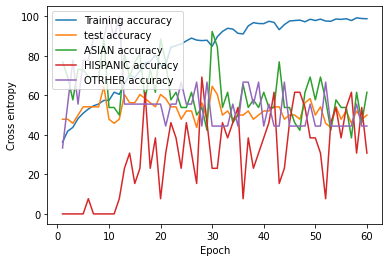

In [103]:
for i in range(len(res_low_train_acc_lst)):
    res_low_train_acc_lst[i] = res_low_train_acc_lst[i].cpu()
    
for j in range(len(res_low_test_acc_lst)):
    res_low_test_acc_lst[j] = res_low_test_acc_lst[j].cpu()

print(best_every_acc_res_low)
plt.plot(range(1, NUM_EPOCHS+1), res_low_train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_low_test_acc_lst, label='test accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_low_ASIAN_ACC, label='ASIAN accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_low_HISPANIC_ACC, label='HISPANIC accuracy')
plt.plot(range(1, NUM_EPOCHS+1), res_low_OTHER_ACC, label='OTRHER accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

混淆矩阵总元素个数：48,测试集总个数:48
[[16.  7.  0.]
 [ 6.  4.  5.]
 [ 4.  2.  4.]]


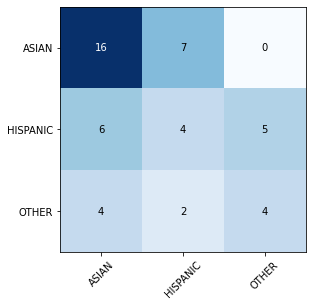

In [104]:
labels = ['ASIAN', 'HISPANIC', 'OTHER']

draw_confusion_matrix(test_low_loader, model_low_res, labels, NUM_CLASSES, DEVICE)

In [123]:
#  实现最终分类器

model_test_res_high = resnet18(NUM_CLASSES)
model_test_res_high.load_state_dict(torch.load("./save/res_high/80.912.pt"))
model_test_res_high.to(DEVICE)

model_test_res_low = resnet18(NUM_CLASSES)
model_test_res_low.load_state_dict(torch.load("./save/res_low/64.583.pt"))
model_test_res_low.to(DEVICE)

model_test_res_high.eval()
model_test_res_low.eval()

img_path = './2391.other.png'

transform_test_high = transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_high_mean, train_high_std)
    ])

transform_test_low = transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_low_mean, train_low_std)
    ])

races = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER']

img = Image.open(img_path)
img_high = transform_test_high(img).unsqueeze(0)
img_low = transform_test_low(img).unsqueeze(0)

img_high = img_high.to(DEVICE)
img_low = img_low.to(DEVICE)

_, probas = model_test_res_high(img_high)
# print(probas)
_, predicted_label = torch.max(probas, 1)
# print(predicted_labels)

if predicted_label == 2:
    _, probas = model_test_res_low(img_low)
    # print(probas)
    _, predicted_label = torch.max(probas, 1)
    # print(predicted_labels)
    if predicted_label == 0:
        predicted_label = 2
    elif predicted_label == 1:
        predicted_label = 3
    elif predicted_label == 2:
        predicted_label = 4

race = races[predicted_label] 
print('The race of the people is:', race)
    

The race of the people is: OTHER


In [48]:
#  实现分类器函数

def race_classifier(img_path, model, high_dict, low_dict, device):
    
    races = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER']
    
    model_test_high = model
    model_test_high.load_state_dict(torch.load(high_dict))
    model_test_high.to(DEVICE)

    model_test_low = model
    model_test_low.load_state_dict(torch.load(low_dict))
    model_test_low.to(DEVICE)
    
    model_test_high.eval()
    model_test_low.eval()
    
    transform_test_high = transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_high_mean, train_high_std)
    ])

    transform_test_low = transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_low_mean, train_low_std)
    ])
    
    img = Image.open(img_path)
    img_high = transform_test_high(img).unsqueeze(0)
    img_low = transform_test_low(img).unsqueeze(0)

    img_high = img_high.to(device)
    img_low = img_low.to(device)
    
    _, probas = model_test_high(img_high)
    # print(probas)
    _, predicted_label = torch.max(probas, 1)
    # print(predicted_labels)

    if predicted_label == 2:
        _, probas = model_test_low(img_low)
        # print(probas)
        _, predicted_label = torch.max(probas, 1)
        # print(predicted_labels)
        if predicted_label == 0:
            predicted_label = 2
        elif predicted_label == 1:
            predicted_label = 3
        elif predicted_label == 2:
            predicted_label = 4
            
    race = races[predicted_label] 
    print('The race of the people is:', race)

In [49]:
high_dict = "./save/res_high/80.912.pt"
low_dict = "./save/res_low/64.583.pt"
img_path = './2391.other.png'
model_test = resnet18(NUM_CLASSES)

race_classifier(img_path, model_test, high_dict, low_dict, DEVICE)

The race of the people is: OTHER


In [51]:
#  DenseNet model

import re
import torch.utils.checkpoint as cp
from collections import OrderedDict



def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet121(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_featuremaps (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [25]:
torch.manual_seed(RANDOM_SEED)

model_high_den = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model_high_den.to(DEVICE)
cost_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_high_den.parameters(), lr=LEARNING_RATE)  

In [26]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    
def every_kind_accuracy(model, data_loader, device):
    classes = ['WHITE', 'BLACK', 'OTHER']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    every_kind = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        for label, prediction in zip(targets, predicted_labels):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        every_kind.append(accuracy)
    return every_kind


start_time = time.time()

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
den_train_acc_lst, den_test_acc_lst = [], []
den_train_loss_lst, den_test_loss_lst = [], []
den_WHITE_ACC, den_BLACK_ACC, den_OTHER_ACC = [], [], []

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path_save = '/home/rush/Face_Recognize/save/den_high/'
best_acc = 150
best_every_acc_den_high = []

for epoch in range(NUM_EPOCHS):
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_high_den.train()
    
    for batch_idx, (features, targets) in enumerate(train_high_loader):
    
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        logits, probas = model_high_den(features)
        cost = cost_fn(logits, targets)
        '''
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0, 1.0, 1.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        '''
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 8:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_high_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_high_den.eval()
    with torch.set_grad_enabled(False):
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        train_acc, train_loss = compute_accuracy_and_loss(model_high_den, train_high_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model_high_den, test_high_loader, device=DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        den_train_acc_lst.append(train_acc)
        den_test_acc_lst.append(test_acc)
        den_train_loss_lst.append(train_loss)
        den_test_loss_lst.append(test_loss)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        every_acc = every_kind_accuracy(model_high_den, test_high_loader, device = DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        den_WHITE_ACC.append(every_acc[0])
        den_BLACK_ACC.append(every_acc[1])
        den_OTHER_ACC.append(every_acc[2])
        
        all_acc = every_acc[0] + every_acc[1] + every_acc[2]
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | test Acc.: {test_acc:.2f}%')
        
    if all_acc > best_acc:
        best_acc = all_acc
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        best_every_acc_den_high = every_acc
        torch.save(model_high_den.state_dict(), path_save + f'{best_acc:.3f}.pt')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/060 | Batch 000/021 | Cost: 1.1468
Epoch: 001/060 | Batch 008/021 | Cost: 1.0932
Epoch: 001/060 | Batch 016/021 | Cost: 1.0316
Accuracy for class WHITE is: 95.5 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 0.0 %
Epoch: 001/060 Train Acc.: 53.79% | test Acc.: 81.31%
Time elapsed: 0.51 min
Epoch: 002/060 | Batch 000/021 | Cost: 1.0486
Epoch: 002/060 | Batch 008/021 | Cost: 0.9404
Epoch: 002/060 | Batch 016/021 | Cost: 0.9292
Accuracy for class WHITE is: 92.8 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 4.2 %
Epoch: 002/060 Train Acc.: 62.95% | test Acc.: 79.11%
Time elapsed: 1.03 min
Epoch: 003/060 | Batch 000/021 | Cost: 0.9391
Epoch: 003/060 | Batch 008/021 | Cost: 0.9024
Epoch: 003/060 | Batch 016/021 | Cost: 0.8997
Accuracy for class WHITE is: 91.1 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 4.2 %
Epoch: 003/060 Train Acc.: 66.24% | test Acc.: 77.66%
Time elapsed: 1.55 min
Epoch: 004/060 | Batch 000/021 | Cost

Accuracy for class WHITE is: 73.3 %
Accuracy for class BLACK is: 63.9 %
Accuracy for class OTHER is: 18.8 %
Epoch: 026/060 Train Acc.: 91.72% | test Acc.: 70.79%
Time elapsed: 13.49 min
Epoch: 027/060 | Batch 000/021 | Cost: 0.2521
Epoch: 027/060 | Batch 008/021 | Cost: 0.3218
Epoch: 027/060 | Batch 016/021 | Cost: 0.3085
Accuracy for class WHITE is: 78.7 %
Accuracy for class BLACK is: 67.5 %
Accuracy for class OTHER is: 12.5 %
Epoch: 027/060 Train Acc.: 91.57% | test Acc.: 75.70%
Time elapsed: 14.01 min
Epoch: 028/060 | Batch 000/021 | Cost: 0.2814
Epoch: 028/060 | Batch 008/021 | Cost: 0.2577
Epoch: 028/060 | Batch 016/021 | Cost: 0.2343
Accuracy for class WHITE is: 74.8 %
Accuracy for class BLACK is: 59.8 %
Accuracy for class OTHER is: 16.7 %
Epoch: 028/060 Train Acc.: 92.11% | test Acc.: 71.54%
Time elapsed: 14.52 min
Epoch: 029/060 | Batch 000/021 | Cost: 0.2473
Epoch: 029/060 | Batch 008/021 | Cost: 0.2906
Epoch: 029/060 | Batch 016/021 | Cost: 0.2749
Accuracy for class WHITE is:

Epoch: 052/060 | Batch 000/021 | Cost: 0.0837
Epoch: 052/060 | Batch 008/021 | Cost: 0.1122
Epoch: 052/060 | Batch 016/021 | Cost: 0.0735
Accuracy for class WHITE is: 65.6 %
Accuracy for class BLACK is: 59.0 %
Accuracy for class OTHER is: 50.0 %
Epoch: 052/060 Train Acc.: 97.10% | test Acc.: 64.38%
Time elapsed: 27.02 min
Epoch: 053/060 | Batch 000/021 | Cost: 0.0980
Epoch: 053/060 | Batch 008/021 | Cost: 0.1012
Epoch: 053/060 | Batch 016/021 | Cost: 0.1062
Accuracy for class WHITE is: 65.5 %
Accuracy for class BLACK is: 58.2 %
Accuracy for class OTHER is: 50.0 %
Epoch: 053/060 Train Acc.: 97.64% | test Acc.: 64.18%
Time elapsed: 27.54 min
Epoch: 054/060 | Batch 000/021 | Cost: 0.0936
Epoch: 054/060 | Batch 008/021 | Cost: 0.0886
Epoch: 054/060 | Batch 016/021 | Cost: 0.1070
Accuracy for class WHITE is: 76.7 %
Accuracy for class BLACK is: 67.9 %
Accuracy for class OTHER is: 31.2 %
Epoch: 054/060 Train Acc.: 97.80% | test Acc.: 74.50%
Time elapsed: 28.05 min
Epoch: 055/060 | Batch 000/0

[74.74985285462037, 70.68273092369478, 37.5]


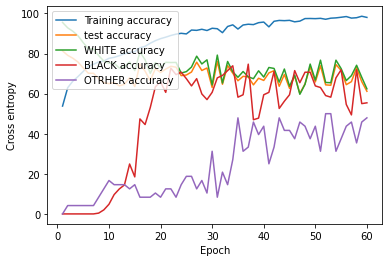

In [27]:
for i in range(len(den_train_acc_lst)):
    den_train_acc_lst[i] = den_train_acc_lst[i].cpu()
    
for j in range(len(den_test_acc_lst)):
    den_test_acc_lst[j] = den_test_acc_lst[j].cpu()

print(best_every_acc_den_high)
plt.plot(range(1, NUM_EPOCHS+1), den_train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_test_acc_lst, label='test accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_WHITE_ACC, label='WHITE accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_BLACK_ACC, label='BLACK accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_OTHER_ACC, label='OTRHER accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [36]:
torch.manual_seed(RANDOM_SEED)

model_low_den = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model_low_den.to(DEVICE)
cost_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_low_den.parameters(), lr=LEARNING_RATE)  

In [37]:
def every_kind_accuracy(model, data_loader, device):
    classes = ['ASIAN', 'HISPANIC', 'OTHER']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    every_kind = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        for label, prediction in zip(targets, predicted_labels):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        #print(total_pred)
            
    for classname, correct_count in correct_pred.items():
        if(total_pred[classname] == 0):
            accuracy = 0.1
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            every_kind.append(accuracy)
        else:
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            every_kind.append(accuracy)
    return every_kind

start_time = time.time()

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
den_low_train_acc_lst, den_low_test_acc_lst = [], []
den_low_train_loss_lst, den_low_test_loss_lst = [], []
den_low_ASIAN_ACC, den_low_HISPANIC_ACC, den_low_OTHER_ACC = [], [], []

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path_save = '/home/rush/Face_Recognize/save/den_low/'
best_acc = 100
best_every_acc_den_low = []

for epoch in range(NUM_EPOCHS):
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_low_den.train()

    for batch_idx, (features, targets) in enumerate(train_low_loader):
    
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        logits, probas = model_low_den(features)
        cost = cost_fn(logits, targets)
        '''
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0, 1.0, 1.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        '''
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 8:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_low_loader):03d} |'
                   f' Cost: {cost:.4f}')

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    model_low_den.eval()
    with torch.set_grad_enabled(False):
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        train_acc, train_loss = compute_accuracy_and_loss(model_low_den, train_low_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model_low_den, test_low_loader, device=DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        den_low_train_acc_lst.append(train_acc)
        den_low_test_acc_lst.append(test_acc)
        den_low_train_loss_lst.append(train_loss)
        den_low_test_loss_lst.append(test_loss)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        every_acc = every_kind_accuracy(model_low_den, test_low_loader, device = DEVICE)
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        den_low_ASIAN_ACC.append(every_acc[0])
        den_low_HISPANIC_ACC.append(every_acc[1])
        den_low_OTHER_ACC.append(every_acc[2])
        
        all_acc = every_acc[0] + every_acc[1] + every_acc[2]
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | test Acc.: {test_acc:.2f}%')
        
    if all_acc > best_acc:
        best_acc = all_acc
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        best_every_acc_den_low = every_acc
        torch.save(model_high_den.state_dict(), path_save + f'{best_acc:.3f}.pt')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/060 | Batch 000/033 | Cost: 1.1379
Epoch: 001/060 | Batch 008/033 | Cost: 1.1369
Epoch: 001/060 | Batch 016/033 | Cost: 1.0943
Epoch: 001/060 | Batch 024/033 | Cost: 1.0981
Epoch: 001/060 | Batch 032/033 | Cost: 1.1034
Accuracy for class ASIAN is: 88.5 %
Accuracy for class HISPANIC is: 7.7 %
Accuracy for class OTHER is: 11.1 %
Epoch: 001/060 Train Acc.: 35.39% | test Acc.: 52.08%
Time elapsed: 0.25 min
Epoch: 002/060 | Batch 000/033 | Cost: 1.0596
Epoch: 002/060 | Batch 008/033 | Cost: 1.0697
Epoch: 002/060 | Batch 016/033 | Cost: 1.0883
Epoch: 002/060 | Batch 024/033 | Cost: 1.0548
Epoch: 002/060 | Batch 032/033 | Cost: 1.1082
Accuracy for class ASIAN is: 30.8 %
Accuracy for class HISPANIC is: 15.4 %
Accuracy for class OTHER is: 66.7 %
Epoch: 002/060 Train Acc.: 42.12% | test Acc.: 33.33%
Time elapsed: 0.50 min
Epoch: 003/060 | Batch 000/033 | Cost: 1.0871
Epoch: 003/060 | Batch 008/033 | Cost: 1.0694
Epoch: 003/060 | Batch 016/033 | Cost: 1.0468
Epoch: 003/060 | Batch 024/

Epoch: 021/060 | Batch 000/033 | Cost: 0.5814
Epoch: 021/060 | Batch 008/033 | Cost: 0.5262
Epoch: 021/060 | Batch 016/033 | Cost: 0.5870
Epoch: 021/060 | Batch 024/033 | Cost: 0.6452
Epoch: 021/060 | Batch 032/033 | Cost: 0.7067
Accuracy for class ASIAN is: 80.8 %
Accuracy for class HISPANIC is: 7.7 %
Accuracy for class OTHER is: 44.4 %
Epoch: 021/060 Train Acc.: 78.40% | test Acc.: 54.17%
Time elapsed: 5.29 min
Epoch: 022/060 | Batch 000/033 | Cost: 0.5821
Epoch: 022/060 | Batch 008/033 | Cost: 0.5692
Epoch: 022/060 | Batch 016/033 | Cost: 0.5549
Epoch: 022/060 | Batch 024/033 | Cost: 0.5956
Epoch: 022/060 | Batch 032/033 | Cost: 0.4580
Accuracy for class ASIAN is: 65.4 %
Accuracy for class HISPANIC is: 61.5 %
Accuracy for class OTHER is: 44.4 %
Epoch: 022/060 Train Acc.: 80.69% | test Acc.: 60.42%
Time elapsed: 5.54 min
Epoch: 023/060 | Batch 000/033 | Cost: 0.5914
Epoch: 023/060 | Batch 008/033 | Cost: 0.6148
Epoch: 023/060 | Batch 016/033 | Cost: 0.5372
Epoch: 023/060 | Batch 024/

Epoch: 041/060 | Batch 000/033 | Cost: 0.2856
Epoch: 041/060 | Batch 008/033 | Cost: 0.2445
Epoch: 041/060 | Batch 016/033 | Cost: 0.2485
Epoch: 041/060 | Batch 024/033 | Cost: 0.2454
Epoch: 041/060 | Batch 032/033 | Cost: 0.2309
Accuracy for class ASIAN is: 53.8 %
Accuracy for class HISPANIC is: 30.8 %
Accuracy for class OTHER is: 55.6 %
Epoch: 041/060 Train Acc.: 93.90% | test Acc.: 47.92%
Time elapsed: 10.30 min
Epoch: 042/060 | Batch 000/033 | Cost: 0.2004
Epoch: 042/060 | Batch 008/033 | Cost: 0.1628
Epoch: 042/060 | Batch 016/033 | Cost: 0.1780
Epoch: 042/060 | Batch 024/033 | Cost: 0.1911
Epoch: 042/060 | Batch 032/033 | Cost: 0.1947
Accuracy for class ASIAN is: 53.8 %
Accuracy for class HISPANIC is: 61.5 %
Accuracy for class OTHER is: 44.4 %
Epoch: 042/060 Train Acc.: 92.06% | test Acc.: 54.17%
Time elapsed: 10.55 min
Epoch: 043/060 | Batch 000/033 | Cost: 0.1859
Epoch: 043/060 | Batch 008/033 | Cost: 0.3083
Epoch: 043/060 | Batch 016/033 | Cost: 0.1589
Epoch: 043/060 | Batch 0

[88.46153846153847, 53.84615384615385, 44.44444444444444]


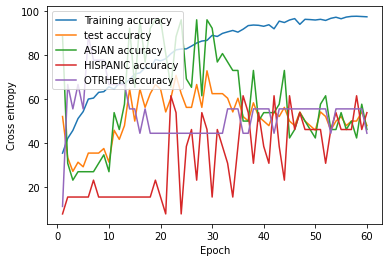

In [38]:
for i in range(len(den_low_train_acc_lst)):
    den_low_train_acc_lst[i] = den_low_train_acc_lst[i].cpu()
    
for j in range(len(den_low_test_acc_lst)):
    den_low_test_acc_lst[j] = den_low_test_acc_lst[j].cpu()

print(best_every_acc_den_low)
plt.plot(range(1, NUM_EPOCHS+1), den_low_train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_low_test_acc_lst, label='test accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_low_ASIAN_ACC, label='ASIAN accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_low_HISPANIC_ACC, label='HISPANIC accuracy')
plt.plot(range(1, NUM_EPOCHS+1), den_low_OTHER_ACC, label='OTRHER accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [54]:
high_dict = "./save/den_high/182.933.pt"
low_dict = "./save/den_low/186.752.pt"
img_path = './3143.asian.png'
model_test = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)

race_classifier(img_path, model_test, high_dict, low_dict, DEVICE)

The race of the people is: ASIAN
